In [1]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
tweets = pd.read_csv(r'C:\Users\nikhi\OneDrive\Desktop\Detecting-Depression-in-Tweets-master\sentiment_tweets3.csv')
tweets.head()

,Unnamed: 0,message,label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [5]:
# dropping the unnamed column
tweets.drop(['Unnamed: 0'],axis = 1, inplace = True)

In [6]:
tweets.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [7]:
# 0 : positive tweet
# 1 : depressing tweet

In [8]:
tweets['label'].value_counts()

0    8000
1    2314
Name: label, dtype: int64

In [9]:
tweets.isnull().sum()

message    0
label      0
dtype: int64

In [10]:
totalTweets = 8000 + 2314
trainIndex, testIndex = list(), list()
for i in range(tweets.shape[0]):
    if np.random.uniform(0, 1) < 0.98:
        trainIndex += [i]
    else:
        testIndex += [i]
trainData = tweets.iloc[trainIndex]
testData = tweets.iloc[testIndex]

In [11]:
trainData.head()

,message,label
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


In [12]:
testData.head()

,message,label
23,@sian_the_mouse yay! a duck! if i want anythin...,0
94,@urbanfly do y' mean M.C Escher (the painter n...,0
109,Am taking advantage of the sunshine and am goi...,0
112,"came back from seeing 17 againn,, was gooddd ...",0
156,@RealWorldMom,0


In [14]:
trainData['label'].value_counts()

0    7850
1    2272
Name: label, dtype: int64

In [15]:
testData['label'].value_counts()

0    150
1     42
Name: label, dtype: int64

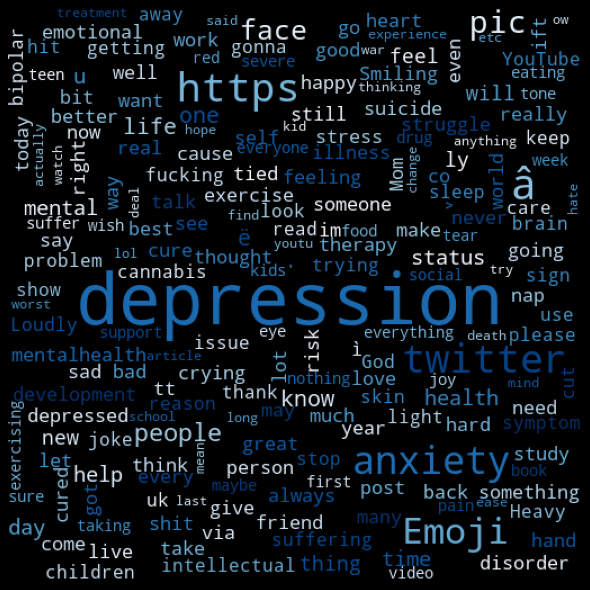

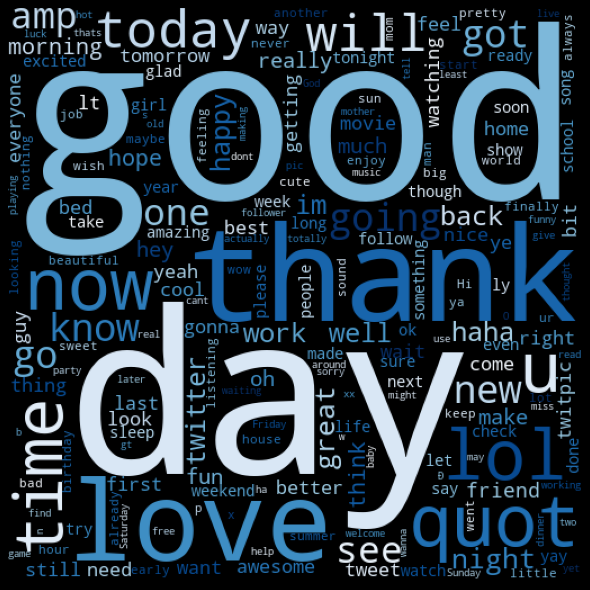

In [16]:
depressive_words = ' '.join(list(tweets[tweets['label'] == 1]['message']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

positive_words = ' '.join(list(tweets[tweets['label'] == 0]['message']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [17]:
def process_message(message, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        message = message.lower()
    words = word_tokenize(message)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [19]:
class TweetClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.tweets, self.labels = trainData['message'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word] + 1) / (self.depressive_words + \
                                                                len(list(self.tf_depressive.keys())))
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word] + 1) / (self.positive_words + \
                                                                len(list(self.tf_positive.keys())))
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 

    def calc_TF_and_IDF(self):
        noOfMessages = self.tweets.shape[0]
        self.depressive_tweets, self.positive_tweets = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_tweets = self.depressive_tweets + self.positive_tweets
        self.depressive_words = 0
        self.positive_words = 0
        self.tf_depressive = dict()
        self.tf_positive = dict()
        self.idf_depressive = dict()
        self.idf_positive = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.tweets.iloc[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels.iloc[i]:
                    self.tf_depressive[word] = self.tf_depressive.get(word, 0) + 1
                    self.depressive_words += 1
                else:
                    self.tf_positive[word] = self.tf_positive.get(word, 0) + 1
                    self.positive_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels.iloc[i]:
                    self.idf_depressive[word] = self.idf_depressive.get(word, 0) + 1
                else:
                    self.idf_positive[word] = self.idf_positive.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_depressive = dict()
        self.prob_positive = dict()
        self.sum_tf_idf_depressive = 0
        self.sum_tf_idf_positive = 0
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.tf_depressive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive[word] + self.idf_positive.get(word, 0)))
            self.sum_tf_idf_depressive += self.prob_depressive[word]
        for word in self.tf_depressive:
            self.prob_depressive[word] = (self.prob_depressive[word] + 1) / (self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
            
        for word in self.tf_positive:
            self.prob_positive[word] = (self.tf_positive[word]) * log((self.depressive_tweets + self.positive_tweets) \
                                                          / (self.idf_depressive.get(word, 0) + self.idf_positive[word]))
            self.sum_tf_idf_positive += self.prob_positive[word]
        for word in self.tf_positive:
            self.prob_positive[word] = (self.prob_positive[word] + 1) / (self.sum_tf_idf_positive + len(list(self.prob_positive.keys())))
            
    
        self.prob_depressive_tweet, self.prob_positive_tweet = self.depressive_tweets / self.total_tweets, self.positive_tweets / self.total_tweets 
                    
    def classify(self, processed_message):
        pDepressive, pPositive = 0, 0
        for word in processed_message:                
            if word in self.prob_depressive:
                pDepressive += log(self.prob_depressive[word])
            else:
                if self.method == 'tf-idf':
                    pDepressive -= log(self.sum_tf_idf_depressive + len(list(self.prob_depressive.keys())))
                else:
                    pDepressive -= log(self.depressive_words + len(list(self.prob_depressive.keys())))
            if word in self.prob_positive:
                pPositive += log(self.prob_positive[word])
            else:
                if self.method == 'tf-idf':
                    pPositive -= log(self.sum_tf_idf_positive + len(list(self.prob_positive.keys()))) 
                else:
                    pPositive -= log(self.positive_words + len(list(self.prob_positive.keys())))
            pDepressive += log(self.prob_depressive_tweet)
            pPositive += log(self.prob_positive_tweet)
        return pDepressive >= pPositive
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [20]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels.iloc[i] == 1 and predictions[i] == 1)
        true_neg += int(labels.iloc[i] == 0 and predictions[i] == 0)
        false_pos += int(labels.iloc[i] == 0 and predictions[i] == 1)
        false_neg += int(labels.iloc[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [21]:
sc_tf_idf = TweetClassifier(trainData, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(testData['message'])
metrics(testData['label'], preds_tf_idf)

Precision:  0.9047619047619048
Recall:  0.4523809523809524
F-score:  0.6031746031746031
Accuracy:  0.8697916666666666


In [22]:
sc_bow = TweetClassifier(trainData, 'bow')
sc_bow.train()
preds_bow = sc_bow.predict(testData['message'])
metrics(testData['label'], preds_bow)

Precision:  0.8461538461538461
Recall:  0.2619047619047619
F-score:  0.4
Accuracy:  0.828125


In [23]:
pm = process_message('Feeling down...')
sc_bow.classify(pm)

False

In [24]:
pm = process_message('Loving how me and my lovely partner is talking about what we want.')
sc_bow.classify(pm)

False

In [25]:
pm = process_message('Hi hello depression and anxiety are the worst')
sc_bow.classify(pm)

True

In [26]:
pm = process_message('My depression will not let me work out')
sc_bow.classify(pm)

True

In [29]:
from tensorflow.keras.preprocessing import image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [32]:
image = cv2.imread("pho.jpeg", 1)
cv2.imshow("original",image)

In [9]:
from PIL import Image
from resizeimage import resizeimage
import cv2
from tensorflow.keras.preprocessing import image

In [11]:
img = image.load_img('pho.jpeg',target_size = (5,7))
img

In [22]:
import numpy as np

In [23]:
img = np.array(img)
cv2.imwrite("5_flip.jpeg",img)

True